In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import random
import logging

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import Trainer
from torch_geometric.data import DataLoader

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from model.model import SingleFramework
from model.hetero_data import DataObject
from utils import load_graph_information

In [3]:
torch.set_default_dtype(torch.float64)
logging.getLogger().setLevel(logging.INFO)

In [4]:
matplotlib.style.use("seaborn")

## Load dataset

In [5]:
# Define seed.
SEED = 1
# Dataset name.
DATASET_TARGET = "synthetic/position/data"

In [6]:
dataset_path = f"../../../datasets/{DATASET_TARGET}"

In [7]:
graph, teams_composition, teams_label, nodes_attribute, teams_members, nodes_name, teams_name = load_graph_information(dataset_path)

INFO:root:Directed graph: False
INFO:root:Number of nodes: 2000
INFO:root:Number of edges: 9000
INFO:root:Number of teams: 200
INFO:root:Number of classes: 3
INFO:root:Number of features for each node: 0
INFO:root:Number of nodes that not belong to any team: 0
INFO:root:Overlapping members of the teams: False


In [8]:
# Define the teams and the team labels.
df_labels = pd.DataFrame(teams_label.items(), columns = ["team", "label"])
df_labels.head()

,team,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [9]:
teams = df_labels["team"].tolist()
n_teams = len(teams)
y = df_labels["label"].to_list()
n_classes = df_labels["label"].nunique()

In [10]:
class_distribution = df_labels["label"].value_counts(normalize = True)
class_distribution

label
0    0.335
1    0.335
2    0.330
Name: proportion, dtype: float64

In [11]:
# Get nodes that not belong to the teams: 'None' value in correspondence of no team belonging.
nodes_not_belong_to_teams = [node for node, teams in teams_composition.items() if teams is None]

## Preprocessing 

In [13]:
random.seed(0)
np.random.seed(0)

HeteroData = DataObject(graph, teams_composition, teams_members, teams_label, nodes_not_belong_to_teams, nodes_attribute, nodes_name)
data = HeteroData(topology = True, centrality = True, position = True)
data

HeteroData(
  n_teams=200,
  y=[200],
  n_classes=3,
  topology={
    x=[2000, 1],
    edge_index=[2, 17600],
    composition=[2000],
    norm=False
  },
  centrality={
    x=[200, 1],
    edge_index=[2, 400],
    edge_weight=[400, 1],
    mask_teams=[200]
  },
  position={
    x=[200, 1],
    dists_max=[200, 49],
    dists_argmax=[200, 49],
    n_anchorsets=49,
    mask_teams=[200]
  }
)

## Training and test

In [14]:
EPOCHS = 100

In [15]:
# Split teams for training and for test.
teams_mask_train = np.full(n_teams, False)
teams_mask_test = np.full(n_teams, False)

train_teams, test_teams, train_labels, test_labels = train_test_split(teams, y, test_size = 0.2, stratify = y, random_state = SEED)

teams_mask_train[train_teams] = True
teams_mask_test[test_teams] = True

data.train_teams, data.train_labels = train_teams, train_labels

In [16]:
test_acc = []
for i in range(1):
    # Fix seed for reproducibility.
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED) 

    # Train and test mask.
    data.mask_train = torch.tensor(teams_mask_train)
    data.mask_test = torch.tensor(teams_mask_test)

    # Normalization attributes.
    if data["topology"].norm:
        # Fit scaler on training data.  
        x_tmp = StandardScaler().fit_transform(data["topology"].x) 
        data["topology"].x_norm = torch.tensor(x_tmp)
    else:
        x_tmp = np.copy(data["topology"].x)  
        data["topology"].x_norm = torch.tensor(x_tmp)

    # Training and test.
    flow_conv_t = "source_to_target"
    model = SingleFramework(input_dim_t = data["topology"].x.shape[1], input_dim_c = data["centrality"].x.shape[1], 
                            input_dim_p = data["position"].x.shape[1], n_anchorsets = data["position"].n_anchorsets, 
                            out_dim = data.n_classes, flow_conv_t = flow_conv_t, epochs = EPOCHS, gat_t = True) 

    train_loader = DataLoader([data], batch_size = 1, shuffle = False)
    trainer = Trainer(gpus = 1, max_epochs = EPOCHS, checkpoint_callback = False, logger = False, weights_summary = None) 
    trainer.fit(model, train_loader)
    result = trainer.test(model, test_dataloaders = train_loader)    
    test_acc.append(result[0]["test_acc"])

print(np.mean(test_acc)*100, np.std(test_acc)*100)

C:\Users\Pietro\Desktop\Mentor\venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
C:\Users\Pietro\Desktop\Mentor\venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

C:\Users\Pietro\Desktop\Mentor\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:899: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 1.0, 'test_auroc': 1.0, 'test_f1': 1.0}
--------------------------------------------------------------------------------
100.0 0.0


## Analysis

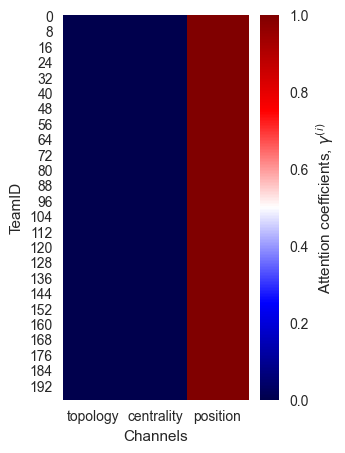

In [17]:
# Plot channel attentions.
att_prob = model.attentions_channels.detach().cpu().numpy()
df = pd.DataFrame(att_prob, columns = model.channels)

fig, axs = plt.subplots(figsize = (3, 5), ncols = 1, nrows = 1)

sns.heatmap(df, vmin = 0, vmax = 1, cmap = "seismic", cbar_kws = {"label": "Attention coefficients, $\gamma^{(i)}$"}, 
            ax = axs)

axs.set_ylabel("TeamID")
axs.set_xlabel("Channels");

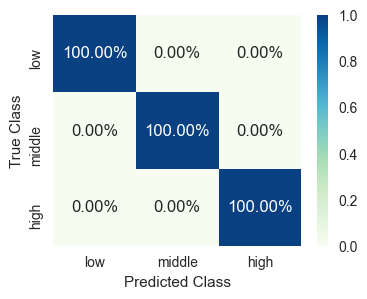

In [18]:
# Load confusion matrix.
cf_matrix = model.confusion_matrix

fig, ax = plt.subplots(figsize = (4, 3), ncols = 1, nrows = 1)

m = cf_matrix / cf_matrix.astype(np.float32).sum(axis = 1)
cax = sns.heatmap(m, annot = True, fmt = ".2%", xticklabels = ["low", "middle", "high"], yticklabels = ["low", "middle", "high"],
                  cmap = "GnBu", linewidths = 0., linecolor = "black", annot_kws = {"fontsize": 12}, 
                  ax = ax)
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class");

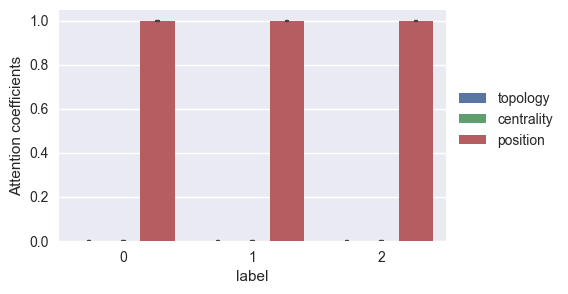

In [19]:
# Get attention coefficients in relation with label.
df = pd.DataFrame(att_prob, columns = model.channels)
df["label"] = pd.Series(teams_label)

fig, axs = plt.subplots(figsize = (5, 3), ncols = 1, nrows = 1)

m = pd.melt(df, id_vars = ["label"], value_vars = ["topology", "centrality", "position"], 
            var_name = "channels", value_name = "Attention coefficients")
sns.barplot(x = "label", hue = "channels", y = "Attention coefficients", data = m, capsize = .02, 
            estimator = np.mean, errwidth = 1.6, ci = 95)

axs.legend(loc = "best", bbox_to_anchor = (1, 0.7));

### Isolated graph (topology)

In [20]:
# Get edges topology GAT attentions.
edges = model.attentions_topology[0].detach().cpu().numpy()
att_edges = model.attentions_topology[1].detach().cpu().numpy()

In [21]:
nodes_attention_edges = []
for team_id in range(n_teams):
    # Keep nodes that belong to the current team.
    nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
    # Subgraph.
    subgraph = HeteroData.isolated_graph.subgraph(nodes)
    # Get the edges index position of the current team.
    mask = np.isin(edges.T, np.array(subgraph.edges())).all(axis = 1)    
    # Add weights to edges.
    weights = dict(zip(list(map(tuple, edges.T[mask])), att_edges[mask].ravel()))

    # Get attention edges.
    df = pd.DataFrame(edges.T[mask], columns = ["id1", "id2"])
    df["weights"] = att_edges[mask]
    df["team"] = team_id

    nodes_attention_edges.append(df)

In [22]:
nodes_attention = pd.concat(nodes_attention_edges, ignore_index = True)
nodes_attention.head()

,id1,id2,weights,team
0,0,2,0.1,0
1,0,3,0.1,0
2,0,4,0.1,0
3,0,5,0.1,0
4,0,6,0.1,0


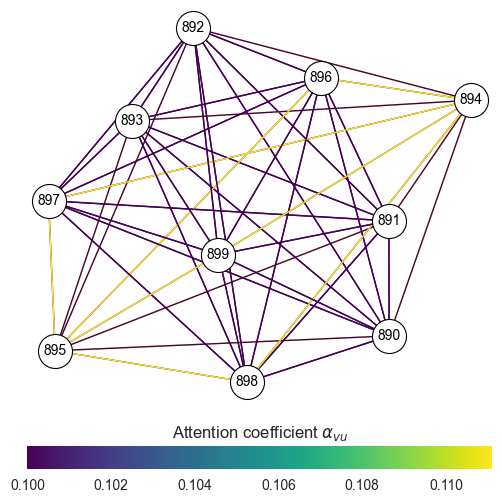

In [23]:
team_id = 89

# Keep nodes that belong to the current team.
nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
# Subgraph.
subgraph = HeteroData.isolated_graph.subgraph(nodes)

nodes_attention_team = nodes_attention.query("team == @team_id").set_index(["id1", "id2"])
edges = nodes_attention_team.index.tolist()
weights = nodes_attention_team["weights"].tolist()

# Get names of the nodes of the isolated subgraphs.
labels = nx.get_node_attributes(subgraph, "Name")
if labels:
    labels = {k: list(nodes_name.keys())[list(nodes_name.values()).index(v)] for k, v in labels.items()}
else:
    labels = None 

# Figure.
fig, ax = plt.subplots(figsize = (6, 6))        
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, edgelist = edges, edge_color = weights, edge_cmap = plt.cm.viridis, connectionstyle = "arc3, rad = 0.1", 
        with_labels = True, labels = labels, linewidths = 0.8, node_size = 600, node_color = "white", font_size = 10, ax = ax)

ax.collections[0].set_edgecolor("black") 

sm = plt.cm.ScalarMappable(cmap = plt.cm.viridis, norm = plt.Normalize(vmin = min(weights), vmax = max(weights)))
sm._A = []
clb = plt.colorbar(sm, orientation = "horizontal", fraction = 0.056, pad = 0.1)
clb.ax.set_title("Attention coefficient $α_{vu}$")
plt.show();

In [24]:
weight_nodes = []
for team_id in range(n_teams):
    # Keep nodes that belong to the current team.
    nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
    # Subgraph.
    subgraph = HeteroData.isolated_graph.subgraph(nodes)
    
    if flow_conv_t == "target_to_source":
        group_key = "id2"
    else:
        group_key = "id1"

    nodes_attention_team = nodes_attention.query("team == @team_id")
    df_sum = nodes_attention_team.groupby([group_key]).agg(weights = ("weights", "sum"), team = ("team", "first"))
    # Add information regarding those nodes that could not have any information (or isolated or not compatible with edge direction).
    df_sum = df_sum.reindex(subgraph.nodes())
    df_sum["team"] = df_sum["team"].fillna(team_id).astype(int)
    df_sum.set_index("team", append = True, inplace = True)
    df_sum.index.names = ["node", "team"]

    weight_nodes.append(df_sum)

In [25]:
weight_nodes = pd.concat(weight_nodes)
weight_nodes.head()

,,weights
node,team,
0,0,0.911111
1,0,0.911111
2,0,1.022222
3,0,1.022222
4,0,1.022222


In [26]:
def hoover(x):
    return (1/2) * (np.sum(np.abs(x - np.mean(x))) / np.sum(x))

In [27]:
indx = weight_nodes.groupby(axis = 0, level = "team").agg(hoover = ("weights", lambda x: hoover(np.abs(x-np.median(x))))) 

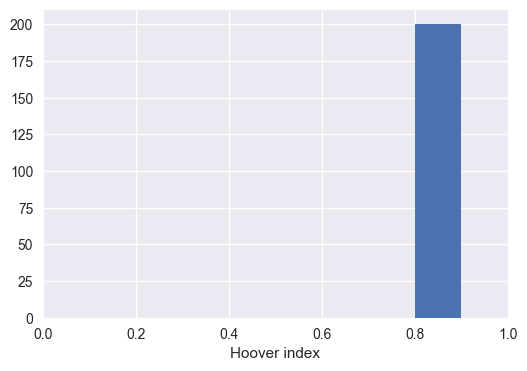

In [28]:
fig, axs = plt.subplots(figsize = (6, 4))

axs.hist(indx["hoover"])
axs.set_xlabel("Hoover index")
axs.set_xlim([0, 1]);